# **CSC490H5 - Semantic Segmentation for Melanoma**
## *Melanoma Boys*



**Instructions:**

This notebook must be run on Google Colaboratory.

In order to run this, you need to have a folder titled CSC490 in your root directory. That folder must also contain folders titled:

*   Model (Copy the one from the repository)
*   ISIC-2017_Training_Data
*   ISIC-2017_Training_Part1_GroundTruth 
*   ISIC-2017_Validation_Data
*   ISIC-2017_Validation_Part1_GroundTruth
*   ISIC-2017_Test_v2_Data
*   ISIC-2017_Test_v2_Part1_GroundTruth

The ISIC folders can be found here: [ISIC 2017 Challenge](https://challenge.isic-archive.com/data/#2017). Unzip the files and upload them to the CSC490 directory. Make sure that each folder contains images and not another folder.

You must run the following sections in order:

1.   Initialization
2.    A. Importing Training/Validation/Test Data (If you are using a certain resolution for the first time)\
      B. Import Preexisting Data (Otherwise)
3.   Pre-Processing
4.   Models
5.   Training
6.   Post-Processing
7.   Testing

NOTE: Generally, you need to run each of the cells in order. However, some cells can be skipped if you have already ran it before (e.g. you don't have to run the cell under "Importing Training Data" if you have already successfully done it before).


### Initialization

This mounts your Google drive to Google Colab. You need to do this so that the notebook can access the dataset.



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


This is needed for CFA post-processing.

In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

This imports all the required packages.

In [ ]:
import pandas
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import cv2 as cv2

from tensorflow import keras, GradientTape
import tensorflow as tf
from keras.layers import *  #Include(Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, BatchNormalization)
from tensorflow.keras.optimizers import Nadam, Adam, SGD

import math

from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb, rgb2gray
from skimage.exposure import adjust_gamma, equalize_adapthist, adjust_log, rescale_intensity, is_low_contrast

from os.path import exists
import glob

from keras import backend as K
import warnings

In [ ]:
tf.test.gpu_device_name()
!ls "/content/gdrive/MyDrive/CSC490/"

### Import Preexisting Data

Resolution: The resolution you want the images to be resized to.

Targets: The checkpoints at which you want to create new files.

In [ ]:
resolution = 256
targets = [1999]

This imports previously converted data. You must run each of the following before running this one:



*   Importing Training Data
*   Importing Validation Data
*   Importing Test Data


In [ ]:
train_x = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/train_x_{}_1.npy'.format(resolution)))
train_x_processed = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/train_x_processed_{}.npy'.format(resolution)))
train_t = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/train_t_{}.npy'.format(resolution)))

valid_x = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/valid_x_{}.npy'.format(resolution)))
valid_x_processed = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/valid_x_processed_{}.npy'.format(resolution)))
valid_t = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/valid_t_{}.npy'.format(resolution)))

In [ ]:
test_x = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/test_x_{}.npy'.format(resolution)))
test_x_processed = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/test_x_processed_{}.npy'.format(resolution)))
test_t = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/test_t_{}.npy'.format(resolution)))

A function that displays the neural nets' inputs and outputs. 

From [here](https://www.tensorflow.org/tutorials/images/segmentation).

In [ ]:
# From https://www.tensorflow.org/tutorials/images/segmentation

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask'] 

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
def display_preprocessing(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Before Preprocessing', 'After Preprocessing']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

### Pre-Processing

This perform the following operations to each input image:

First, each image’s contrast was increased by normalizing it, then performing gamma correction and CLAHE on it. Finally, a superpixel representation of each image was generated using K-means clustering segmentation.

In [ ]:
def preprocess_img(image, super_pixels=True):
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Raise contrast of image
    processed_img = adjust_gamma(rescale_intensity(image.numpy()) , gamma=1.8, gain=1)
    processed_img = rescale_intensity(equalize_adapthist(processed_img))

    # Create a superpixel representation of the image
    if not super_pixels:
      return processed_img
    segments = slic(processed_img, n_segments = 300, sigma = 5)

    return tf.cast(tf.reshape(label2rgb(segments, processed_img, kind='avg'), image.shape), tf.float32)



This preprocesses our dataset and saves it to the drive.

In [ ]:
train_x_processed = tf.map_fn(preprocess_img, train_x, fn_output_signature=tf.float32)
np.save('/content/gdrive/MyDrive/CSC490/train_x_processed_{}.npy'.format(resolution), train_x_processed.numpy())

In [ ]:
valid_x_processed = tf.map_fn(preprocess_img, valid_x, fn_output_signature=tf.float32)
np.save('/content/gdrive/MyDrive/CSC490/valid_x_processed_{}.npy'.format(resolution), valid_x_processed.numpy())
test_x_processed = tf.map_fn(preprocess_img, test_x, fn_output_signature=tf.float32)
np.save('/content/gdrive/MyDrive/CSC490/test_x_processed_{}.npy'.format(resolution), test_x_processed.numpy())

In [ ]:
# This tests our preprocessing efforts.
i = randint(0, len(test_x))
pp = preprocess_img(test_x[i], True)
display_preprocessing([test_x[i], pp])

### Importing Training Data

This resizes all of our training set images to the resolution indicated by the parameter "resolution", stores all of the images in a numpy array and saves it to the drive.

It also makes a new numpy file for every checkpoint reached (the checkpoints are stored in the targets variable).

Only run this if something is wrong with the training npy files or you want to use a different resolution (that hasn't been previously been used).

In [ ]:
'''
train_x = tf.zeros([0, resolution, resolution, 3])
train_t = tf.zeros([0, resolution, resolution, 1])

i = 0
j = 1
for file in glob.glob("/content/gdrive/MyDrive/CSC490/ISIC-2017_Training_Data/*.jpg"):
  img = tf.io.read_file(file)
  img = tf.image.decode_jpeg(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [resolution, resolution])
  train_x = tf.concat([train_x, tf.reshape(img, [1, resolution, resolution, 3])], axis=0)
  path = "/content/gdrive/MyDrive/CSC490/ISIC-2017_Training_Part1_GroundTruth/ISIC_{}_segmentation.png".format(file.split('/')[-1].split('.')[0].split('_')[-1])
  if exists(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [resolution, resolution])
    train_t = tf.concat([train_t, tf.reshape(mask, [1, resolution, resolution, 1])], axis=0)
  if i == targets[j - 1]:
    np.save('/content/gdrive/MyDrive/CSC490/train_x_{}_{}.npy'.format(resolution, j), train_x.numpy())
    np.save('/content/gdrive/MyDrive/CSC490/train_t_{}_{}.npy'.format(resolution, j), train_t.numpy())
    train_x = tf.zeros([0, resolution, resolution, 3])
    train_t = tf.zeros([0, resolution, resolution, 1])
    j += 1
  i += 1

np.save('/content/gdrive/MyDrive/CSC490/train_x_{}_{}.npy'.format(resolution, j), train_x.numpy())
np.save('/content/gdrive/MyDrive/CSC490/train_t_{}_{}.npy'.format(resolution, j), train_t.numpy())
'''

In [ ]:
# This checks if the training arrays were properly created
print(len(train_x), train_x.shape)
if len(train_x) > 0:
  i = randint(0, len(train_x) - 1)
  display([train_x[i], train_t[i]])
  print(i)

### Importing Validation Data

This resizes all of our validation set images to the resolution indicated by the parameter "resolution", stores all of the images in a numpy array and saves it to the drive.

Only run this if something is wrong with the validation npy files or you want to use a different resolution (that hasn't been previously been used).

In [ ]:
'''
valid_x = tf.zeros([0, resolution, resolution, 3])
valid_t = tf.zeros([0, resolution, resolution, 1])

for file in glob.glob("/content/gdrive/MyDrive/CSC490/ISIC-2017_Validation_Data/*.jpg"):
  img = tf.io.read_file(file)
  img = tf.image.decode_jpeg(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [resolution, resolution])
  valid_x = tf.concat([valid_x, tf.reshape(img, [1, resolution, resolution, 3])], axis=0)
  path = "/content/gdrive/MyDrive/CSC490/ISIC-2017_Validation_Part1_GroundTruth/ISIC_{}_segmentation.png".format(file.split('/')[-1].split('.')[0].split('_')[-1])
  if exists(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [resolution, resolution])
    valid_t = tf.concat([valid_t, tf.reshape(mask, [1, resolution, resolution, 1])], axis=0)
'''
np.save('/content/gdrive/MyDrive/CSC490/valid_x_{}.npy'.format(resolution), valid_x.numpy())
np.save('/content/gdrive/MyDrive/CSC490/valid_t_{}.npy'.format(resolution), valid_t.numpy())


In [ ]:
# This checks if the validation arrays were properly created
print(len(valid_x), valid_x.shape)
if len(valid_x) > 0:
  i = randint(0, len(valid_x) - 1)
  display([valid_x[i], valid_t[i]])
  print(i)

### Importing Testing Data

This resizes all of our test set images to the resolution indicated by the parameter "resolution", stores all of the images in a numpy array and saves it to the drive.

Only run this if something is wrong with the testing npy files or you want to use a different resolution (that hasn't been previously been used).

In [ ]:
'''
test_x = tf.zeros([0, resolution, resolution, 3])
test_t = tf.zeros([0, resolution, resolution, 1])

for file in glob.glob("/content/gdrive/MyDrive/CSC490/ISIC-2017_Test_v2_Data/*.jpg"):
  img = tf.io.read_file(file)
  img = tf.image.decode_jpeg(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [resolution, resolution])
  test_x = tf.concat([test_x, tf.reshape(img, [1, resolution, resolution, 3])], axis=0)
  path = "/content/gdrive/MyDrive/CSC490/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_{}_segmentation.png".format(file.split('/')[-1].split('.')[0].split('_')[-1])
  if exists(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [resolution, resolution])
    test_t = tf.concat([test_t, tf.reshape(mask, [1, resolution, resolution, 1])], axis=0)

test_x = tf.convert_to_tensor(test_x)
test_t = tf.convert_to_tensor(test_t)

np.save('/content/gdrive/MyDrive/CSC490/test_x_{}.npy'.format(resolution), test_x.numpy())
np.save('/content/gdrive/MyDrive/CSC490/test_t_{}.npy'.format(resolution), test_t.numpy())
'''

In [ ]:
# This checks if the test arrays were properly created
print(len(test_x))
if len(test_x) > 0:
  i = randint(0, len(test_x) - 1)
  display([test_x[i], test_t[i]])
  print(i)

### Models

#### U-Net

A typical implementation of Unet, inspired by:

*   O. Ronneberger, P. Fischer, en T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation”, CoRR, vol abs/1505.04597, 2015.

Here is a diagram of the model:
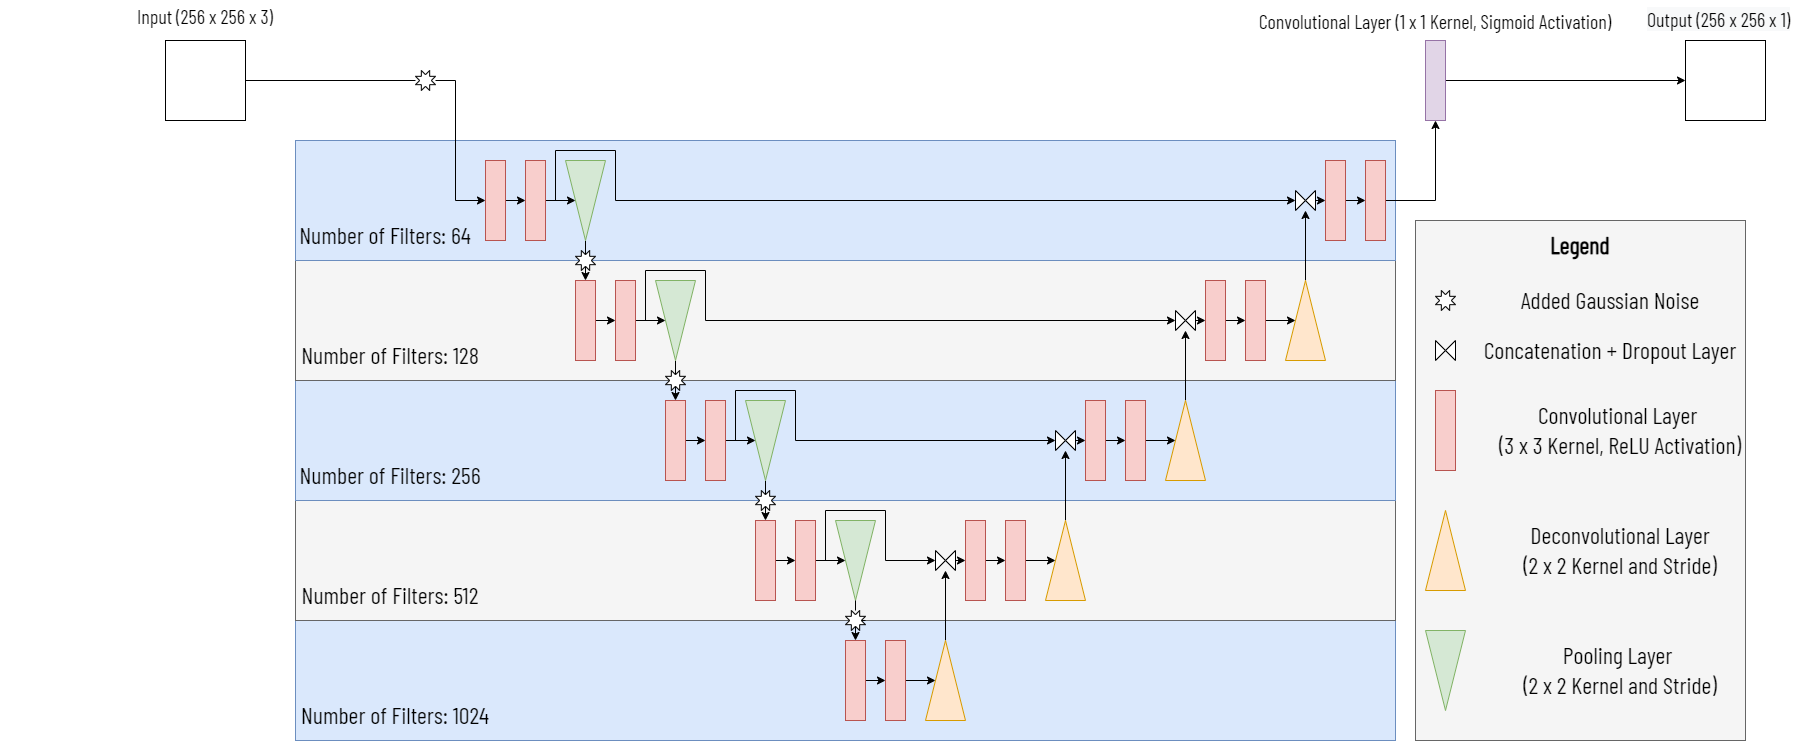

In [ ]:
def unet(img_shape, loss , optimizer, metrics, kernel_size=(3, 3)):
    secondary_kernel = (2, 2)

    inputs = Input(img_shape, name="SkinCancer")
    noise_one = GaussianNoise(0.025)(inputs)

    # Encoder

    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_one)
    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_one)
    down_pooling_one = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_one)
    noise_two = GaussianNoise(0.025)(down_pooling_one)

    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_two)
    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_two)
    down_pooling_two = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_two)
    noise_three = GaussianNoise(0.025)(down_pooling_two)

    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_three)
    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_three)
    down_pooling_three = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_three)
    noise_four = GaussianNoise(0.025)(down_pooling_three)

    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_four)
    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_four)
    down_pooling_four = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_four)
    noise_five = GaussianNoise(0.025)(down_pooling_four)

    down_conv_five = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_five)
    down_conv_five = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_five)
    drop_one = Dropout(0.1)(down_conv_five)
    
    # Decoder

    up_conv_one = Conv2DTranspose(filters=512, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(drop_one)
    merge_one = concatenate([down_conv_four, up_conv_one])
    drop_two = Dropout(0.1)(merge_one)
    up_conv_one = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_two)
    up_conv_one = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_one)
    
    up_conv_two = Conv2DTranspose(filters=256, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_one)
    merge_two = concatenate([down_conv_three, up_conv_two])
    drop_three = Dropout(0.1)(merge_two)
    up_conv_two = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_three)
    up_conv_two = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_two)
    

    up_conv_three = Conv2DTranspose(filters=128, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_two)
    merge_three = concatenate([down_conv_two, up_conv_three])
    drop_four = Dropout(0.1)(merge_three)
    up_conv_three = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_four)
    up_conv_three = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_three)

    up_conv_four = Conv2DTranspose(filters=64, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_three)
    merge_four = concatenate([down_conv_one, up_conv_four])
    drop_five = Dropout(0.1)(merge_four)
    up_conv_four = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_five)
    up_conv_four = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_four)

    final_conv = Convolution2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up_conv_four)

    model = keras.Model(inputs=inputs, outputs=final_conv)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model



#### U-Net Alternative (6 Levels Deep)

All sources used:

Source: https://github.com/zhixuhao/unet

This is an alternative U-Net function with 6 levels of convolutional layers based on Brandon's original version of U-Net function.

It has 6 convolutional layers and up to 2048 filters.

This model is trained with 5 epochs with a batch size of 5 and 256x256 image resolution.

In [ ]:
def unet_alternative(img_shape, loss , optimizer, metrics, kernel_size=(3, 3)):
    secondary_kernel = (2, 2)

    inputs = Input(img_shape, name="SkinCancer")
    noise_one = GaussianNoise(0.025)(inputs)

    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_one)
    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_one)
    down_pooling_one = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_one)
    noise_two = GaussianNoise(0.025)(down_pooling_one)

    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_two)
    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_two)
    down_pooling_two = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_two)
    noise_three = GaussianNoise(0.025)(down_pooling_two)

    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_three)
    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_three)
    down_pooling_three = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_three)
    noise_four = GaussianNoise(0.025)(down_pooling_three)

    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_four)
    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_four)
    down_pooling_four = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_four)
    noise_five = GaussianNoise(0.025)(down_pooling_four)

    down_conv_five = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_five)
    down_conv_five = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_five)
    down_pooling_five = MaxPooling2D(pool_size=(2,2), strides=(2,2))(down_conv_five)
    noise_six = GaussianNoise(0.025)(down_pooling_five)

    down_conv_six = Conv2D(filters=2048, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_six)
    down_conv_six = Conv2D(filters=2048, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_six)
    drop_one = Dropout(0.1)(down_conv_six)
    


    up_conv_one = Conv2DTranspose(filters=1024, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(drop_one)
    merge_one = concatenate([down_conv_five, up_conv_one])
    drop_two = Dropout(0.1)(merge_one)
    up_conv_one = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_two)
    up_conv_one = Conv2D(filters=1024, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_one)

    up_conv_two = Conv2DTranspose(filters=512, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_one)
    merge_two = concatenate([down_conv_four, up_conv_two])
    drop_three = Dropout(0.1)(merge_two)
    up_conv_two = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_three)
    up_conv_two = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_two)

    up_conv_three = Conv2DTranspose(filters=256, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_two)
    merge_three = concatenate([down_conv_three, up_conv_three])
    drop_four = Dropout(0.1)(merge_three)
    up_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_four)
    up_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_three)

    up_conv_four = Conv2DTranspose(filters=128, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_three)
    merge_four = concatenate([down_conv_two, up_conv_four])
    drop_five = Dropout(0.1)(merge_four)
    up_conv_four = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_five)
    up_conv_four = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_four)

    up_conv_five = Conv2DTranspose(filters=64, kernel_size=secondary_kernel, strides=(2,2), kernel_initializer='he_normal')(up_conv_four)
    merge_five = concatenate([down_conv_one, up_conv_five])
    drop_six = Dropout(0.1)(merge_five)
    up_conv_five = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(drop_six)
    up_conv_five = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(up_conv_five)

    final_conv = Convolution2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up_conv_five)

    model = keras.Model(inputs=inputs, outputs=final_conv)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

#### CDNN

All the sources used:

Source: https://github.com/manideep2510/melanoma_segmentation

Source: Yading Yuan, Automatic skin lesion segmentation with fully
convolutional-deconvolutional networks, https://arxiv.org/pdf/1703.05165.pdf

CDNN general model illustration

 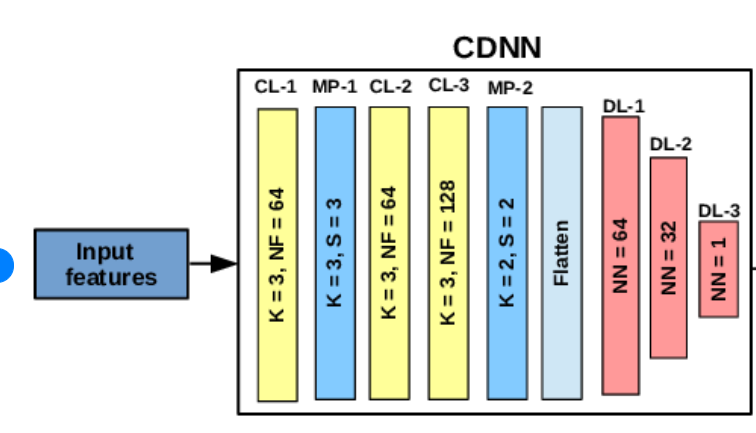

Source:  Mannem, Renuka & Mallela, Jhansi & Illa, Aravind & Ghosh, Prasanta. (2019). Acoustic and Articulatory Feature Based Speech Rate Estimation Using a Convolutional Dense Neural Network. 929-933. 10.21437/Interspeech.2019-2295. ​

Specific features used for this model found in research paper.

In [ ]:
# Fully convulational network
def jaccard_distance(y_true, y_pred, smooth=100):
    # from https://github.com/manideep2510/melanoma_segmentation
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    # from https://github.com/manideep2510/melanoma_segmentation
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def model_seg():
  # from https://github.com/manideep2510/melanoma_segmentation
  # Convolution Layers (BatchNorm after non-linear activation)

  img_shape = (resolution, resolution, 3)
  img_input = Input(img_shape, name="SkinCancer")
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((256,256))(x)
  
  model = keras.Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])

  return model

#### DeepLab V1 (Traditional Convolution before ASPP)

This is an implementation of the Deeplab architecture using a U-Net like feature extractor. 

Sources: 

*   S.-H. Tsang, “Review: Deeplabv3+ - atrous separable convolution (semantic segmentation),” Medium, 30-Sep-2019. [Online]. Available: https://sh-tsang.medium.com/review-deeplabv3-atrous-separable-convolution-semantic-segmentation-a625f6e83b90. [Accessed: 22-Nov-2021].
*   B. S. Ko, “DeepLab: Deep labelling for Semantic Image segmentation,” Home, 25-Aug-2018. [Online]. Available: https://kobiso.github.io/research/research-deeplab/. [Accessed: 22-Nov-2021].




In [ ]:
def deeplab_v1(img_shape, loss , optimizer, metrics):
    kernel_size = (3, 3)

    inputs = Input(img_shape, name="SkinCancer")
    batch_inputs = BatchNormalization()(inputs)

    # Encoder

    low_features = Conv2D(filters=img_shape[0] , kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(batch_inputs)

    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(low_features)
    down_conv_one = Conv2D(filters=64, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_one)
    down_pooling_one = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(down_conv_one)
    noise_two = GaussianNoise(0.025)(down_pooling_one)

    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_two)
    down_conv_two = Conv2D(filters=128, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_two)
    down_pooling_two = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(down_conv_two)
    noise_three = GaussianNoise(0.025)(down_pooling_two)

    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_three)
    down_conv_three = Conv2D(filters=256, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_three)
    down_pooling_three = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(down_conv_three)
    noise_four = GaussianNoise(0.025)(down_pooling_three)

    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(noise_four)
    down_conv_four = Conv2D(filters=512, kernel_size=kernel_size, activation="relu", kernel_initializer='he_normal', padding="same")(down_conv_four)
    down_pooling_four = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(down_conv_four)
    noise_five = GaussianNoise(0.025)(down_pooling_four)

    prev = DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2, kernel_initializer='he_normal', padding="same")(noise_five)

    # ASPP

    pyramid = [Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(prev)]

    for i in range(1, 4):
      pyramid.append(DepthwiseConv2D(kernel_size=(3,3), dilation_rate=6*i, kernel_initializer='he_normal', padding="same")(prev))
      
    # Decoder

    encoded = concatenate(pyramid)
    encoded = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(encoded)

    up_sample = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoded)
    merged = concatenate([down_conv_three, up_sample])

    final_block = Conv2D(filters=1, kernel_size=(3,3), kernel_initializer='he_normal', padding="same")(merged)
    final_block = UpSampling2D(size=(4, 4), interpolation='bilinear')(final_block)

    model = keras.Model(inputs=inputs, outputs=final_block)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

#### DeepLab V2 (ResNeXt-type feature before ASPP)

Similar to V1, except we use ResNeXt blocks for feature extraction.

Source: *S. Xie, R. Girshick, P. Dollár, Z. Tu, en K. He, “Aggregated Residual Transformations for Deep Neural Networks”, arXiv [cs.CV]. 2017.*

In [ ]:
def deeplab_v2(img_shape, loss , optimizer, metrics, cardinality=4):
    inputs = Input(img_shape, name="SkinCancer")
    batch_inputs = BatchNormalization()(inputs)

    # Encoder

    low_features = Conv2D(filters=img_shape[0] , kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(batch_inputs)
    prev = low_features
    size = img_shape[0]

    for_upscale = None
    paths = []
    for j in range(4):
      if j == 2:
        for_upscale = prev
      paths.append([])
      for i in range(cardinality):
        paths[j].append(Conv2D(filters=size/2, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(prev))
        paths[j][i] = BatchNormalization()(paths[j][i])
        paths[j][i] = ReLU()(paths[j][i])
        paths[j][i] = Conv2D(filters=size/2, kernel_size=(3,3), kernel_initializer='he_normal', padding="same")(paths[j][i])
        paths[j][i] = BatchNormalization()(paths[j][i])
        paths[j][i] = ReLU()(paths[j][i])
        paths[j][i] = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(paths[j][i])
        paths[j][i] = BatchNormalization()(paths[j][i])
        paths[j][i] = ReLU()(paths[j][i])
      resnext = add(paths[j])
      resnext = add([resnext, prev])
      size /= (2 ** j)
      prev = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(resnext)

    prev = DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2, kernel_initializer='he_normal', padding="same")(prev)

    # ASPP

    pyramid = [DepthwiseConv2D(kernel_size=(1,1), kernel_initializer='he_normal', padding="same")(prev)]

    for i in range(1, 4):
      pyramid.append(DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2*i, kernel_initializer='he_normal', padding="same")(prev))
    encoded = concatenate(pyramid)
    encoded = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(encoded)

    # Decoder

    up_sample = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoded)
    merged = concatenate([for_upscale, up_sample])

    final_block = Conv2D(filters=1, kernel_size=(3,3), kernel_initializer='he_normal', padding="same")(merged)
    final_block = UpSampling2D(size=(4, 4), interpolation='bilinear')(final_block)

    model = keras.Model(inputs=inputs, outputs=final_block)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

#### DeepLab V3 (With Grouped Convolutions)

Like V2, except we use grouped convolutions instead of loops to implement the ResNeXt blocks. 


Source: *S. Xie, R. Girshick, P. Dollár, Z. Tu, en K. He, “Aggregated Residual Transformations for Deep Neural Networks”, arXiv [cs.CV]. 2017.*

In [ ]:
def deeplab_v3(img_shape, loss , optimizer, metrics):
    inputs = Input(img_shape, name="SkinCancer")
    batch_inputs = BatchNormalization()(inputs)

    # Encoder

    low_features = Conv2D(filters=img_shape[0] , kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(batch_inputs)
    prev = low_features
    size = img_shape[0]

    for_upscale = None
    paths = []
    for j in range(4):
      if j == 2:
        for_upscale = prev
      paths.append(Conv2D(filters=size/2, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(prev))
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      paths[j] = Conv2D(filters=size/2, kernel_size=(3,3), groups=16, kernel_initializer='he_normal', padding="same")(paths[j])
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      paths[j] = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(paths[j])
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      resnext = add([paths[j], prev])
      size /= (2 ** j)
      prev = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(resnext)

    prev = DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2, kernel_initializer='he_normal', padding="same")(prev)

    # ASPP

    pyramid = [DepthwiseConv2D(kernel_size=(1,1), kernel_initializer='he_normal', padding="same")(prev)]

    for i in range(1, 4):
      pyramid.append(DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2*i, kernel_initializer='he_normal', padding="same")(prev))
    encoded = concatenate(pyramid)
    encoded = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(encoded)

    # Decoder

    up_sample = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoded)
    merged = concatenate([for_upscale, up_sample])

    final_block = Conv2D(filters=1, kernel_size=(3,3), kernel_initializer='he_normal', padding="same")(merged)
    final_block = UpSampling2D(size=(4, 4), interpolation='bilinear')(final_block)

    model = keras.Model(inputs=inputs, outputs=final_block)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

#### DeepLab V4 (Combined models)

The same model as V3 with a final sigmoid layer. 

Here are all the sources used to create this (reiterating from above)


*    S. Xie, R. Girshick, P. Dollár, Z. Tu, en K. He, “Aggregated Residual Transformations for Deep Neural Networks”, arXiv [cs.CV]. 2017.
*   S.-H. Tsang, “Review: Deeplabv3+ - atrous separable convolution (semantic segmentation),” Medium, 30-Sep-2019. [Online]. Available: https://sh-tsang.medium.com/review-deeplabv3-atrous-separable-convolution-semantic-segmentation-a625f6e83b90. [Accessed: 22-Nov-2021].
*     B. S. Ko, “DeepLab: Deep labelling for Semantic Image segmentation,” Home, 25-Aug-2018. [Online]. Available: https://kobiso.github.io/research/research-deeplab/. [Accessed: 22-Nov-2021].



This is the model depicted in the diagram below:

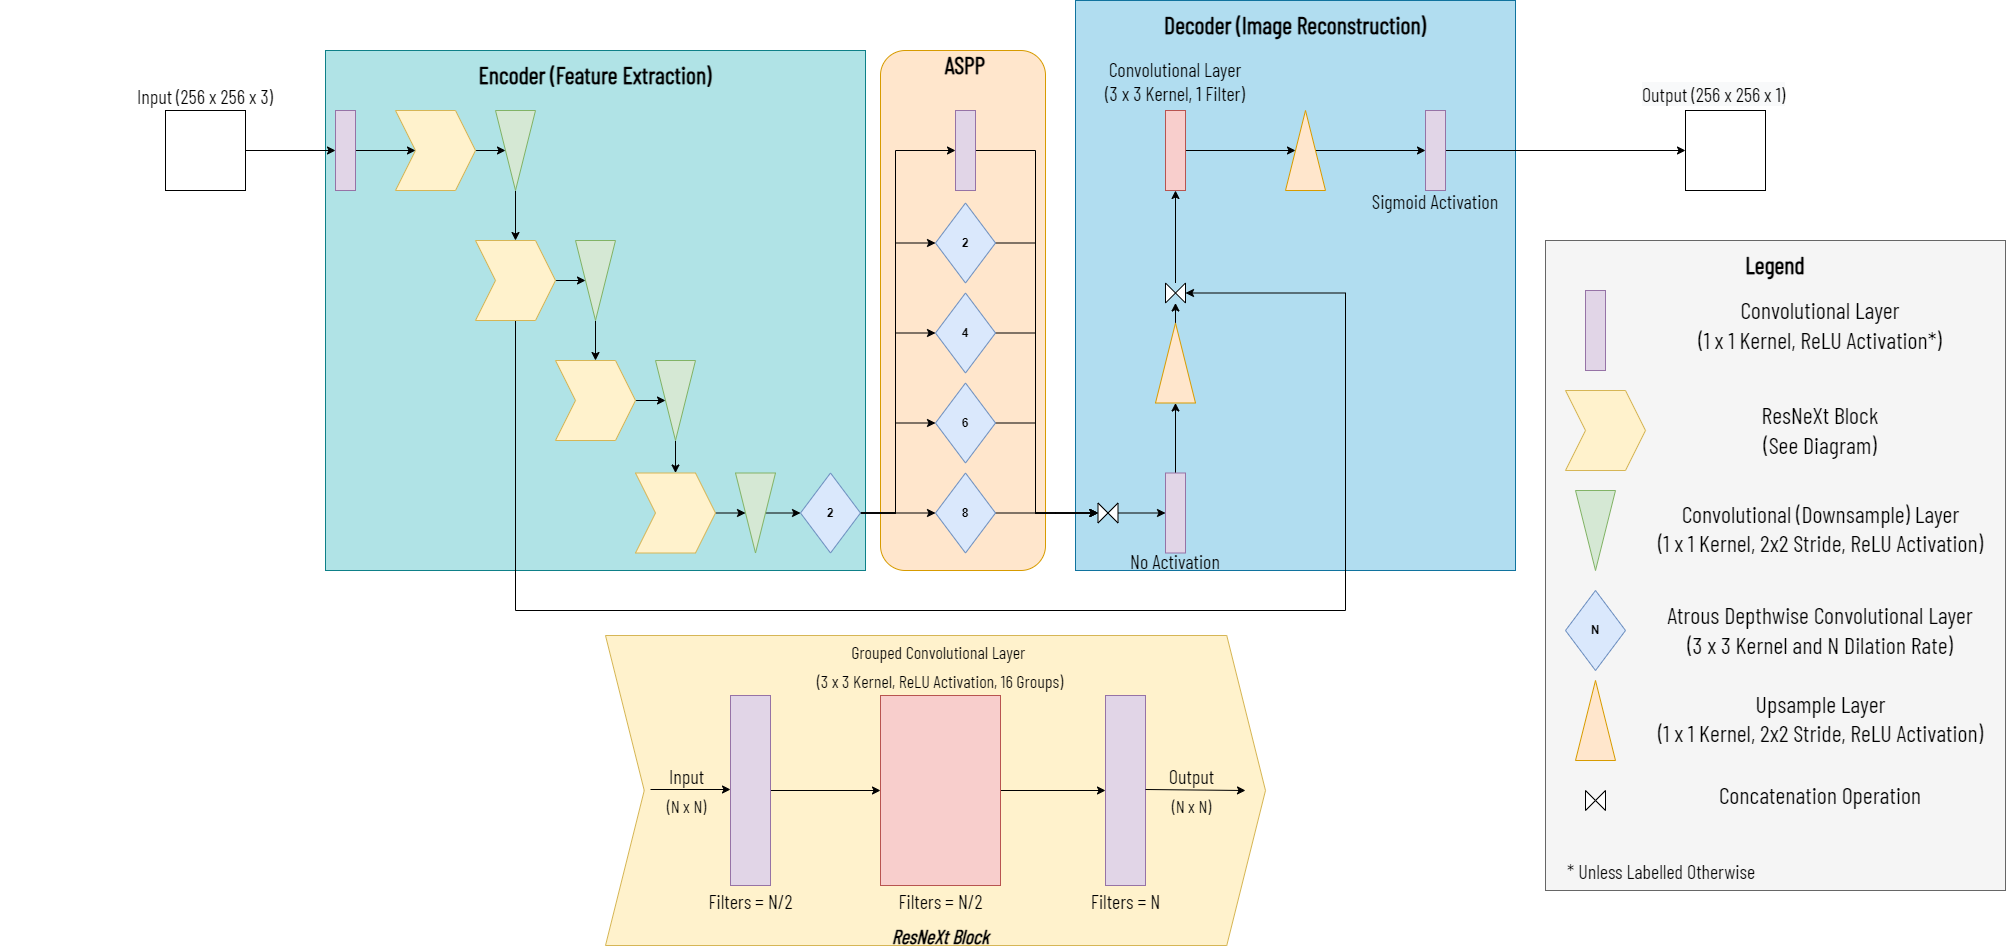



In [ ]:
def deeplab_v4(img_shape, loss , optimizer, metrics):
    inputs = Input(img_shape, name="SkinCancer")
    batch_inputs = BatchNormalization()(inputs)

    # Encoder

    low_features = Conv2D(filters=img_shape[0] , kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(batch_inputs)
    prev = low_features
    size = img_shape[0]

    for_upscale = None
    paths = []
    for j in range(4):
      if j == 2:
        for_upscale = prev
      paths.append(Conv2D(filters=size/2, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(prev))
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      paths[j] = Conv2D(filters=size/2, kernel_size=(3,3), groups=16, kernel_initializer='he_normal', padding="same")(paths[j])
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      paths[j] = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(paths[j])
      paths[j] = BatchNormalization()(paths[j])
      paths[j] = ReLU()(paths[j])
      resnext = add([paths[j], prev])
      size /= (2 ** j)
      prev = Conv2D(filters=size, kernel_size=(1,1), strides=(2,2), kernel_initializer='he_normal', padding="same")(resnext)

    prev = DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2, kernel_initializer='he_normal', padding="same")(prev)

    # ASPP

    pyramid = [DepthwiseConv2D(kernel_size=(1,1), kernel_initializer='he_normal', padding="same")(prev)]

    for i in range(1, 4):
      pyramid.append(DepthwiseConv2D(kernel_size=(3,3), dilation_rate=2*i, kernel_initializer='he_normal', padding="same")(prev))
    encoded = concatenate(pyramid)
    encoded = Conv2D(filters=size, kernel_size=(1,1), kernel_initializer='he_normal', padding="valid")(encoded)

    # Decoder

    up_sample_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(encoded)
    merged = concatenate([for_upscale, up_sample_1])

    up_sample_2 = Conv2D(filters=1, kernel_size=(3,3), kernel_initializer='he_normal', padding="same")(merged)
    up_sample_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(up_sample_2)

    final_block = Convolution2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up_sample_2)

    model = keras.Model(inputs=inputs, outputs=final_block)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

### Training

This cell initializes one of the models (indicated by the model_name and version parameters) defined above. It also sets all the parameters needed for training.

This **must** be run before the next cell.

Note that "Unet v2" and "Deeplab v4" just load pretrained weights. These weights can be found in the "Model" directory. You can skip the "Training" Section if you want to use them.

In [ ]:
  batch_size = 16
  epochs = 3

  img_shape = (resolution, resolution, 3)

  # From https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
  def dice_loss():
    def bce_dice(t, y):
      t_flat = K.flatten(t)
      y_flat = K.flatten(y)
      smooth = 1e-6

      num = 2 * K.sum(t_flat * y_flat) + smooth
      denom = K.sum(K.square(t_flat)) + K.sum(K.square(y_flat)) + smooth

      return 1 - num/denom + keras.losses.binary_crossentropy(t_flat, y_flat)
    return bce_dice
  loss = dice_loss()
  optimizer = keras.optimizers.Adam()
  metrics = [tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.MeanIoU(num_classes=2)]

  # Change these variables to indicate what model you want to train/use
  model_name = "deeplab"
  version = 4

  if model_name == "unet":
    if version == 1:

      model = unet(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)

      batch_size = 5
      epochs = 20
    
    elif version == 2:
      
      model = unet(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)
      model.load_weights("/content/gdrive/MyDrive/CSC490/Model/weights_unet_preprocessed.h5")

      model_backup = unet(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)
      model_backup.load_weights("/content/gdrive/MyDrive/CSC490/Model/weights_unet.h5")

      batch_size = 5
      epochs = 20

  elif model_name == "unet_alternative":

    model = unet_alternative(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)

    batch_size = 5
    epochs = 5

  elif model_name == "cdnn":

    model = model_seg()

    batch_size = 16
    epochs = 3

  elif model_name == "deeplab":
    if version == 1:

      model = deeplab_v1(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)

      batch_size = 3
      epochs = 5

    elif version == 2:

      model = deeplab_v2(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)

      batch_size = 3
      epochs = 10
    
    elif version == 3:

      model = deeplab_v3(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)

      batch_size = 5
      epochs = 20
    
    elif version == 4:
      
      model = deeplab_v4(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=metrics)
      model.load_weights("/content/gdrive/MyDrive/CSC490/Model/weights_deeplab_preprocessed.h5")

      model_backup = deeplab_v3(img_shape=img_shape, loss=loss, optimizer=optimizer, metrics=[metrics[0]])
      model_backup.load_weights("/content/gdrive/MyDrive/CSC490/Model/weights_deeplab.h5")

      batch_size = 5
      epochs = 20

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/CSC490/Model/cp-{epoch:04d}-" + model_name + "-x" + str(resolution) + "-.ckpt", 
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

This chunk of code trains any given model.

In [ ]:
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

def train_model(x, v, t):
  model.fit(x=x,
            y=t,
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True,
            validation_data=(v, valid_t),
            callbacks=[checkpoint_callback],
            verbose=1)
  
# Change train_x_processed to train_x if you don't want preprocessing. The same goes for valid_x_processed and valid_x.
train_model(train_x_processed, valid_x_processed, train_t)

# Trains the model with the rest of the training set (if we split it into different files)
for _ in range(len(targets) - 1):
  train_x = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/train_x_{}_{}.npy'.format(resolution, num)))
  train_t = tf.convert_to_tensor(np.load('/content/gdrive/MyDrive/CSC490/train_t_{}_{}.npy'.format(resolution, num)))
  train_model(train_x, valid_x, train_t)

# Saves the weights to Google Drive
i = 0
parent_path = "/content/gdrive/MyDrive/CSC490/Model/"
file_path = parent_path + "weights_x{}_{}_v{}.h5".format(resolution, model_name, i)
while exists(file_path):
    i += 1
    file_path = parent_path + "weights_x{}_{}_mk{}_v{}.h5".format(resolution, model_name, version if model_name == 'deeplab' else 0, i)
model.save_weights(file_path, save_format='h5')

### Post-Processing

This perform the following operations on the input mask:

First, a series of opening and closing operations is performed on the image to get rid of gaps and isolated blobs. Kernel sizes of 3, 5, 7, and 9 are ysed. Then, everything but the the biggest contour is discarded.

In [ ]:
def post_process(image):
  padding_size = 10

  padded = np.pad(np.reshape(image, (resolution, resolution)), pad_width=padding_size, mode='constant', constant_values=0)
  img_mat = cv2.UMat(np.uint8(padded))
  # Repeated open and close operations

  kernel_sizes = [(3, 3), (5, 5), (7, 7), (9, 9)]
  for _ in range(3):
    for kernel in kernel_sizes:
      img_mat = cv2.morphologyEx(img_mat, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel))
    for kernel in kernel_sizes:
      img_mat = cv2.morphologyEx(img_mat, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel))
  
  # Detects Edges
  thresh = cv2.Canny(img_mat, 0, 1)

  # Gets contours from edges
  contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

  # Gets the biggest contour by area
  if contours == []:
      return tf.reshape(img_mat.get()[padding_size:-padding_size, padding_size:-padding_size], image.shape)
  biggest = max(contours, key=cv2.contourArea)
  
  # Produce a new matrix only containing the biggest contour
  img_mat = np.zeros((resolution + 2 * padding_size,resolution + 2 * padding_size), dtype=np.uint8)
  cv2.drawContours(img_mat, [biggest], 0, 1, cv2.FILLED)

  return tf.reshape(img_mat[padding_size:-padding_size, padding_size:-padding_size], image.shape)

### Testing

Use this to load any saved weights.

In [ ]:
# Load checkpoint weights
# model.load_weights("/content/gdrive/MyDrive/CSC490/Model/cp-0004.ckpt")
# Load final weights
# model.load_weights("/content/gdrive/MyDrive/CSC490/Model/cp-0017-unet-x256-.ckpt")
# model.load_weights("/content/gdrive/MyDrive/CSC490/Model/weights_deeplab_preprocessed.h5")

This evalutates the loss and accuracy of our model using built-in processes. This is only suitable for evaluating models without post-processing.

In [ ]:
score = model.evaluate(test_x_processed, test_t, batch_size=batch_size, verbose=1) 

print('{} Test loss:'.format(model_name), score[0]) 
print('{} Test accuracy:'.format(model_name), score[1])

This generates our prediction mask. It uses two models (if available); one trained on raw 256x256 images and the other on pre-processed images. Both models used a threshold of 0.5 to assign labels. A CRF is also used to make inferences based on the calculated probabilities. If any of the three inputs label a pixel “1”, the final output will label said pixel “1”.

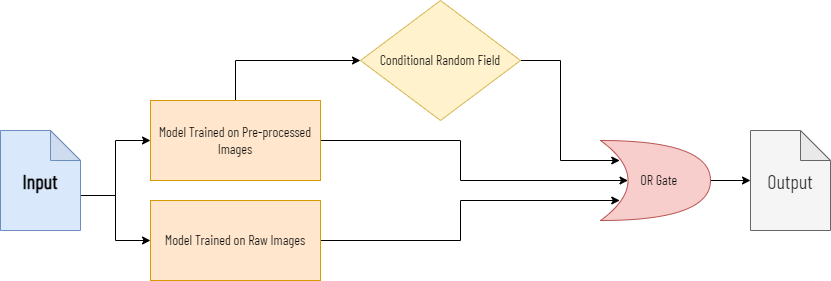

In [ ]:
def predict(arr, index):
    image = arr[i]
    pred =  model_backup.predict(tf.reshape(image, [1, resolution, resolution, 3]))[0]

    # Converts prediction into binary mask
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    
    # Initializes CRF to make inferences from our prediciton
    crf = tf.reshape(tfa.layers.CRF(2)(pred)[0], [resolution, resolution, 1]).numpy()

    # We only use model_backup if it exists (we know deeplab v4 and unet v2 use it)
    if ((model_name == "deeplab" and version == 4) or (model_name == "unet" and version == 2)) and np.amax(pred) == 0:

        # Converts prediction (from a model trained on non-preprocessed data) into binary mask
        pred_2 = model_backup.predict(tf.reshape(image, [1, resolution, resolution, 3]))[0]
        pred_2[pred >= 0.5] = 1
        pred_2[pred < 0.5] = 0

        # We don't use the CRF if it outputs all 0s or all 1s (it will throw off the whole prediction)
        if np.max(crf) == 1 and np.min == 0:
            pred = pred + pred_2 + crf
        else:
            pred = pred + pred_2

        # If either model or the CRF assignes 1 to a pixel, we set that pixel to 1. If neither model nor the CRF assigns 1 to said
        # pixel, we set it to 0.
        pred[pred >= 1] = 1
        pred[pred < 1] = 0
    else:
        # If the model or the CRF assignes 1 to a pixel, we set that pixel to 1. If the model and the CRF assigns 0 to said
        # pixel, we set it to 0.
        if np.max(crf) == 1 and np.min == 0:
            pred = pred + crf
        pred[pred >= 1] = 1
        pred[pred < 1] = 0
    return pred

This chunk of code evaluates the model after post-processing has been conducted on its output.

In [ ]:
test_loss = 0
test_bin_acc = 0
test_iou_acc = 0

for i in range(len(test_x)):
    # Make predictions, apply post-processing, then convert it to a tensor (so loss and accuracy can be calculated)
    pred_y = post_process(predict(test_x, i))
    pred_y = tf.cast(tf.convert_to_tensor(pred_y), tf.float32)

    # Calculate loss
    loss_mat = loss(test_t[i], pred_y)
    test_loss += float(tf.reduce_mean(loss_mat))

    # Calculate accuracy
    bin_acc_mat = metrics[0](test_t[i], pred_y)
    test_bin_acc += float(tf.reduce_mean(bin_acc_mat))
    iou_acc_mat = metrics[1](test_t[i], pred_y)
    test_iou_acc += float(tf.reduce_mean(iou_acc_mat))

# Calculate averages
test_loss /= len(test_x)
test_bin_acc /= len(test_x)
test_iou_acc /= len(test_x)

print('{} Test loss:'.format(model_name), test_loss) 
print('{} Test binary accuracy:'.format(model_name), test_bin_acc)
print('{} Test IOU accuracy:'.format(model_name), test_iou_acc)

This displays the model's prediction generated from a random, test set image.

In [ ]:
# 129 - Edge on the border

i = randint(0, len(test_x))

print("Image #{}\n".format(i))
pred_y = predict(test_x, i)
print("--- Before Post-Processing ---")
display([test_x[i], test_t[i], pred_y])

pred_y = post_process(pred_y)
print("--- After Post-Processing ---")
display([test_x[i], test_t[i], pred_y])